In [1]:
import requests
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from coinmarketcap import Market
import json
import time

from bittrex.bittrex import Bittrex, API_V2_0


In [4]:
#CryptoCompare Functions
#**TO-DO** Comment the Functions

def price(symbol, comparison_symbols=['USD'], exchange=''):
    url = 'https://min-api.cryptocompare.com/data/price?fsym={}&tsyms={}'\
            .format(symbol.upper(), ','.join(comparison_symbols).upper())
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()
    return data

def daily_price_historical(symbol, comparison_symbol, all_data=True, limit=1, aggregate=1, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    if all_data:
        url += '&allData=true'
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

def hourly_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

def minute_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histominute?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

def coin_list():
    url = 'https://www.cryptocompare.com/api/data/coinlist/'
    page = requests.get(url)
    data = page.json()['Data']
    return data

def coin_snapshot_full_by_id(symbol, symbol_id_dict={}):
    if not symbol_id_dict:
        symbol_id_dict = {
            'BTC': 1182,
            'ETH': 7605,
            'LTC': 3808
        }
    symbol_id = symbol_id_dict[symbol.upper()]
    url = 'https://www.cryptocompare.com/api/data/coinsnapshotfullbyid/?id={}'\
            .format(symbol_id)
    page = requests.get(url)
    data = page.json()['Data']
    return data

def live_social_status(symbol, symbol_id_dict={}):
    if not symbol_id_dict:
        symbol_id_dict = {
            'BTC': 1182,
            'ETH': 7605,
            'LTC': 3808
        }
    symbol_id = symbol_id_dict[symbol.upper()]
    url = 'https://www.cryptocompare.com/api/data/socialstats/?id={}'\
            .format(symbol_id)
    page = requests.get(url)
    data = page.json()['Data']
    return data

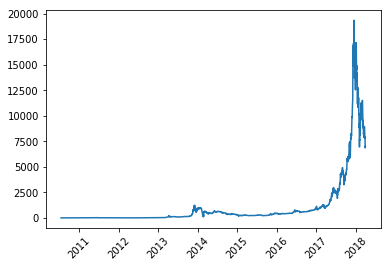

In [5]:
df = daily_price_historical('BTC', 'USD')
plt.plot(df.timestamp, df.close)
plt.xticks(rotation=45)
plt.show()

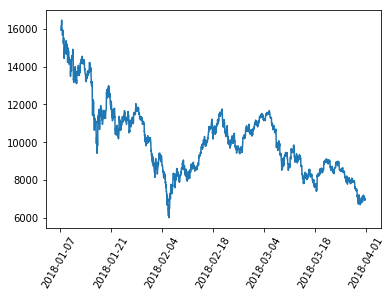

In [6]:
hourly_df = hourly_price_historical('BTC','USD',10000,1)
plt.plot(hourly_df.timestamp,hourly_df.close)
plt.xticks(rotation= 60)
plt.show()

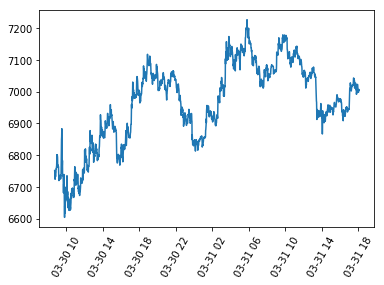

In [7]:
min_df = minute_price_historical('BTC','USD',10000,1)
plt.plot(min_df.timestamp,min_df.close)
plt.xticks(rotation= 60)
plt.show()

In [2]:
#CoinMarketCap Functions

coinmarketcap = Market()
coinmarketcap.ticker(start=0, limit=3, convert='USD')

[{u'24h_volume_usd': u'4504500000.0',
  u'available_supply': u'16950525.0',
  u'cached': True,
  u'id': u'bitcoin',
  u'last_updated': u'1522544667',
  u'market_cap_usd': u'119162529760',
  u'max_supply': u'21000000.0',
  u'name': u'Bitcoin',
  u'percent_change_1h': u'0.3',
  u'percent_change_24h': u'0.15',
  u'percent_change_7d': u'-19.06',
  u'price_btc': u'1.0',
  u'price_usd': u'7030.02',
  u'rank': u'1',
  u'symbol': u'BTC',
  u'total_supply': u'16950525.0'},
 {u'24h_volume_usd': u'1298730000.0',
  u'available_supply': u'98538881.0',
  u'cached': True,
  u'id': u'ethereum',
  u'last_updated': u'1522544653',
  u'market_cap_usd': u'39204285113.0',
  u'max_supply': None,
  u'name': u'Ethereum',
  u'percent_change_1h': u'0.1',
  u'percent_change_24h': u'-1.55',
  u'percent_change_7d': u'-24.42',
  u'price_btc': u'0.0569905',
  u'price_usd': u'397.856',
  u'rank': u'2',
  u'symbol': u'ETH',
  u'total_supply': u'98538881.0'},
 {u'24h_volume_usd': u'273777000.0',
  u'available_supply': u

In [2]:
my_bittrex = Bittrex(None, None, api_version=API_V2_0)  # or defaulting to v1.1 as Bittrex(None, None)
my_bittrex.get_markets()

Exception: method call not available under API version v2.0

In [3]:
#GDAX Functions
api_base = 'https://api-public.sandbox.gdax.com'
response = requests.get(api_base + '/products')
#print(response.json())

def products():
    response = requests.get(api_base + '/products')
    # check for invalid api response
    if response.status_code is not 200:
        raise Exception('Invalid GDAX Status Code: %d' % response.status_code)
    return response.json()



[{u'quote_currency': u'USD', u'status': u'online', u'post_only': False, u'display_name': u'BTC/USD', u'margin_enabled': True, u'cancel_only': False, u'quote_increment': u'0.01', u'limit_only': False, u'base_max_size': u'10000', u'max_market_funds': None, u'min_market_funds': None, u'base_currency': u'BTC', u'status_message': None, u'id': u'BTC-USD', u'base_min_size': u'0.01'}, {u'quote_currency': u'GBP', u'status': u'online', u'post_only': False, u'display_name': u'BTC/GBP', u'margin_enabled': False, u'cancel_only': False, u'quote_increment': u'0.01', u'limit_only': False, u'base_max_size': u'10000', u'max_market_funds': None, u'min_market_funds': None, u'base_currency': u'BTC', u'status_message': None, u'id': u'BTC-GBP', u'base_min_size': u'0.01'}, {u'quote_currency': u'EUR', u'status': u'online', u'post_only': False, u'display_name': u'BTC/EUR', u'margin_enabled': False, u'cancel_only': False, u'quote_increment': u'0.01', u'limit_only': False, u'base_max_size': u'10000', u'max_market